# Bayesian unfolding using Metropolis-Hastings sampling method

This notebook demonstrates how MCMC sampling algorithm can be used for Bayesian unfolding on a simple 1 dimensional data as a proof of concept.

In [1]:
import MCMC_MH as mcmc
import measure_func as meas

import numpy as np
import scipy.stats as stats
from scipy.interpolate import interp1d

import pickle
import cloudpickle

### Generate data: true and measured

In [2]:
shift = 1
resolution = 1.0
    
theta = stats.norm(loc=3, scale=1).rvs(size=10000)
X = np.array([meas.gaus_homoscedastic(th, shift, resolution) for th in theta])

### Set up MH sampling 

In [3]:
kde = stats.gaussian_kde(X).pdf

def prior_normal(theta):
    return stats.norm(loc=0, scale=3).pdf(theta)

def likfn(theta, Xobs_lik):
    likhood = stats.norm(loc=theta + shift, scale=resolution).pdf(Xobs_lik)
    return likhood

def efffn(effbins, begin, end):
    effs = np.array([stats.norm(loc=effbin+shift, scale=resolution).cdf(end)
                            -stats.norm(loc=effbin+shift, scale=resolution).cdf(begin)
                            for effbin in effbins])
    interpol =interp1d(effbins, effs)    
    return interpol    

### Run MH sampling algorithm 
Now we study dependence on different sample sizes and number of iterations

In [4]:
mh = mcmc.MH_sampling(X, None) 
mh.prior_pdf = kde
mh.likelihood_fn = likfn
mh.integrate_effect =True
mh.measurement_pdf = kde
mh.measurement_eff = efffn(mh.cbins, mh.Xbegin, mh.Xend)

thetas0, accept_rates0,logs0 = mh.get_sample_Bayes(1, 
                            mcmc.q_normal, mcmc.qprob_normal,                                        
                            nsample=20000)

In [5]:
mh.prior_pdf = stats.gaussian_kde(thetas0).pdf
thetas1, accept_rates1,logs1 = mh.get_sample_Bayes(1, 
                            mcmc.q_normal, mcmc.qprob_normal,                                        
                            nsample=20000)

In [6]:
mh.prior_pdf = stats.gaussian_kde(thetas1).pdf
thetas2, accept_rates2,logs2 = mh.get_sample_Bayes(1, 
                            mcmc.q_normal, mcmc.qprob_normal,                                        
                            nsample=20000)

In [7]:
# save trace and model in pickle file for later use
pickle_filepath = f'MH_Bayes_unfold.pkl'

dict_to_save = {'datatrue': theta,
                'datameas': X,
                'thetas0': thetas0,
                'thetas1': thetas1,
                'thetas2': thetas2,                
                'accept_rates0' : accept_rates0,
                'accept_rates1' : accept_rates1,
                'accept_rates2' : accept_rates2               
                }

with open(pickle_filepath , 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)   

### Plot results

In [8]:
import pickle
import cloudpickle
# open a saved file
pickle_filepath = f'MH_Bayes_unfold_q2.0.pkl'
with open(pickle_filepath , 'rb') as buff:
    model_dict = cloudpickle.load(buff)
gen = model_dict['datatrue']
mea = model_dict['datameas']
the0 = model_dict['thetas0']
the1 = model_dict['thetas1']
the2 = model_dict['thetas2']
acc0 = model_dict['accept_rates0']

Mean acceptance rate:  0.625


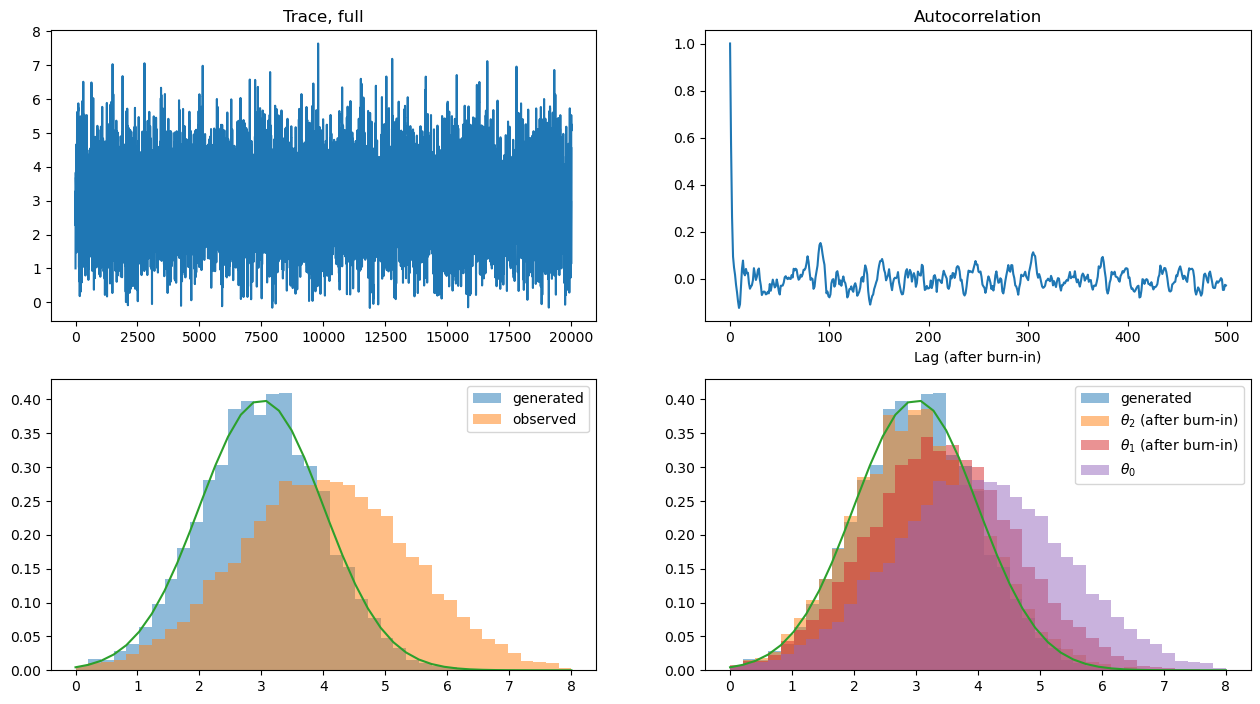

In [9]:
import numpy as np
import scipy.stats as stats
import make_plot as mp
import autocorrelation as acf
burnin=100
maxlags = 500
acf1 = acf.autocorr_fft(the1[burnin:1000],range(maxlags))

nbins = 40
begin, end = 0,8
bins = np.linspace(begin, end, num=nbins)
genfunc = stats.norm.pdf(bins, loc=3, scale=1)

mp.plot_tra_acf_unf(the0, the1, gen, genfunc, mea, acf1, burnin, bins)
print(f"Mean acceptance rate: {np.mean(acc0[0:]): .3f}")